In [1]:
import numpy as np
from nptyping import NDArray
import random
import numpy.linalg as LA
import matplotlib.pyplot as plt
from typing import List, Set, Dict, Tuple, Optional, Any, Callable
from PIL import Image
import os
import json

In [2]:
from utils import load_image_to_arr, display_rgb, SVD2D
import dim_reduction
from spectral_data import ImageSpectralData
dim_reduction.init_basis_cache()
import cityscapes_helper
from dataset_creation import (
    MultiScaleImageSampler, 
    ImageChunkSummarizerOptions, 
    MultiScaleImageEncoder, 
    MultiScaleImageDecoder,
    MultiScaleMultiResolutionImageSampler,
    DownsampledImageAtScale,
    ImageAtScale, 
    CityscapesDatasetFactory, 
    WholeImage,
    CityScapesDataset,
    semantic_image_composition
)
from cityscapes_helper import format_semantic_composition

In [3]:
# Ben Desptop
cityscapes_helper.set_visual_data_zip_path("C:\\Users\\Ben\\Downloads\\leftImg8bit_trainvaltest.zip")
cityscapes_helper.set_semantic_data_zip_path("C:\\Users\\Ben\\Downloads\\gtFine_trainvaltest.zip")

#Ben Laptop (via WSL)
#cityscapes_helper.set_visual_data_zip_path("/mnt/c/Users/benki/Downloads/leftImg8bit_trainvaltest.zip")
#cityscapes_helper.set_semantic_data_zip_path("/mnt/c/Users/benki/Downloads/gtFine_trainvaltest.zip")

cityscapes_helper.initialize_tool()

In [4]:
dataset = CityScapesDataset("full_dataset_v1_30000")
dataset.load()
normalized_features = dataset.get_normalized_features()
print(dataset.labels.shape)
print(dataset.features.shape)

0.npy
1.npy
2.npy
3.npy
4.npy
5.npy
6.npy


c:\Users\Ben\Documents\UW-Vision-Segmentation\dataset_creation.py:685: RuntimeWarning: invalid value encountered in true_divide
  feature_01 = (features - self.raw_feature_min) / feature_range
c:\Users\Ben\Documents\UW-Vision-Segmentation\dataset_creation.py:704: RuntimeWarning: invalid value encountered in true_divide
  feature_01 = (features - feature_min) / feature_range


(30000, 30)
(30000, 701)


In [5]:
def anchor_grid(largest_scale: int, smallest_scale: int) -> List[List[Tuple[int, int]]]:
    CITYSCAPES_Y = 1024
    CITYSCAPES_X = 2048

    #total_margin = largest_scale - smallest_scale
    num_rows = (CITYSCAPES_Y - largest_scale) // smallest_scale
    num_cols = (CITYSCAPES_X - largest_scale) // smallest_scale
    result = []
    for row_i in range(num_rows):
        curr_row = []
        anchor_y = row_i * smallest_scale
        for col_i in range(num_cols):
            anchor_x = col_i * smallest_scale
            curr_row.append([anchor_y, anchor_x])
        result.append(curr_row)
    return result

def multiscale_image_grid(anchor_grid: List[List[Tuple[int, int]]], sampler: MultiScaleMultiResolutionImageSampler, img: NDArray[Any]) -> List[List[List[DownsampledImageAtScale]]]:
    #flat_anchors =  [item for sublist in anchor_grid for item in sublist]
    #flat_multiscale_images = [sampler.sample(img, anchor) for anchor in flat_anchors]
    i = 0
    result = []
    whole_image_scale = WholeImage(img)
    for anchor_row in anchor_grid:
        image_row = []
        for anchor in anchor_row:
            multiscaleImages = sampler.sample(img, anchor)
            multiscaleImages.insert(0, whole_image_scale)
            image_row.append(multiscaleImages)
        result.append(image_row)
    return result

def semantic_composition_grid(sceneID: str, scales: List[int]):
    smallest_scale = scales[-1]
    core_oneside_margin = int((scales[0] - smallest_scale) / 2)
    semantic_composition = cityscapes_helper.loadSemanticInfo(sceneID)
    ag = anchor_grid(scales[0], scales[-1])
    nrows = len(ag)
    ncols = len(ag[0])
    num_classes = 30
    result = np.zeros((nrows, ncols, num_classes))
    for row_i in range(nrows):
        for col_i in range(ncols):
            anchor_Y, anchor_X = ag[row_i][col_i]
            core_anchor_Y = anchor_Y + core_oneside_margin
            core_anchor_X = anchor_X + core_oneside_margin
            semantic_core = semantic_composition[core_anchor_Y:core_anchor_Y+smallest_scale, core_anchor_X:core_anchor_X+smallest_scale]
            result[row_i, col_i, :] = semantic_image_composition(semantic_core)
    return result
import time
def feature_grid(sceneID: str, encoder: MultiScaleImageEncoder, scales: List[int], downsample_factors: List[int]):
    image = cityscapes_helper.loadVisualInfo(sceneID)
    sampler = MultiScaleMultiResolutionImageSampler(scales, downsample_factors, image)
    print(image.shape)
    sampler.compute_downsamples()
    ag = anchor_grid(scales[0], scales[-1])
    image_grid = multiscale_image_grid(ag, sampler, image)
    nrows = len(image_grid)
    ncols = len(image_grid[0])
    print(nrows, ncols)
    print(image_grid[0][0])

    dumbo = [[scaleImage] for scaleImage in image_grid[0][0]]
    first_feature = encoder.encode(dumbo)
    feature_size = first_feature.shape[1]

    wumb = 0

    n_all_scales = len(image_grid[0][0])
    flattened_chunks: List[List[ImageAtScale]] = [[] for i in range(len(image_grid[0][0]))]
    for row_i in range(nrows):
        for col_i in range(ncols):
            for scale_i in range(n_all_scales):
                lil = image_grid[row_i][col_i][scale_i]
                flattened_chunks[scale_i].append(lil)
    print("about to encode")
    #print(flattened_chunks)
    encoded_features_tall = encoder.encode(flattened_chunks)
    print("done encoding")
    wumb = 0
    result = np.zeros((len(image_grid), len(image_grid[0]), feature_size))
    for row_i in range(nrows):
        for col_i in range(ncols):
            result[row_i, col_i, :] = encoded_features_tall[wumb] 
            #start = time.time()
            wumb += 1
            #multiscale_image = image_grid[row_i][col_i]
            #dumbo = [[scaleImage] for scaleImage in multiscale_image]
            #result[row_i, col_i, :] =  encoder.encode(dumbo)[0]
            #fin = time.time()
            #print(f"i: {wumb}, time: {round(fin - start, 5)}")

    #for row_i in range(nrows):
    #    for col_i in range(ncols):
    #        #start = time.time()
    #        wumb += 1
    #        multiscale_image = image_grid[row_i][col_i]
    #        dumbo = [[scaleImage] for scaleImage in multiscale_image]
    #        result[row_i, col_i, :] =  encoder.encode(dumbo)[0]
    #        fin = time.time()
            #print(f"i: {wumb}, time: {round(fin - start, 5)}")

    return result
    

scales = [240, 96, 32]

whole_img_options = ImageChunkSummarizerOptions()
whole_img_options.downsample_factor = 8
whole_img_options.n_pcm_coeffs = [80, 40, 30]

opt_240 = ImageChunkSummarizerOptions()
opt_240.downsample_factor = 3
opt_240.n_pcm_coeffs = [120, 40, 20]

opt_96 = ImageChunkSummarizerOptions()
opt_96.downsample_factor = 2
opt_96.n_pcm_coeffs = [120, 40, 20]

opt_32 = ImageChunkSummarizerOptions()
opt_32.downsample_factor = 1
opt_32.n_pcm_coeffs = [60, 20, 15]

chunk_summarizer_options = [whole_img_options, opt_240, opt_96, opt_32]
downsample_factors = [3, 2, 1]

multiscaleEncoder = MultiScaleImageEncoder(chunk_summarizer_options)
print(multiscaleEncoder.n_scales)
aceneid, img = cityscapes_helper.loadRandomVisualInfo()

    

4


stuttgart_000167


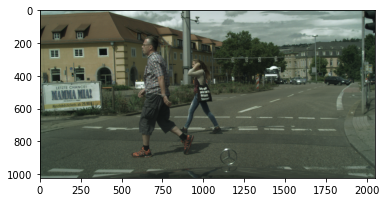

In [39]:
(scene_id, (vis, sem)) = cityscapes_helper.loadRandomScene()
#scene_id = "cologne_000038"
vis = cityscapes_helper.loadVisualInfo(scene_id)
print(scene_id)
display_rgb(vis)

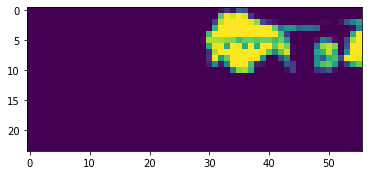

In [40]:
cologne_000038_semantic_grid = semantic_composition_grid(scene_id, scales)
cologne_000038_semantic_grid.shape

foliage_semantic_map = cologne_000038_semantic_grid[:, :, 21]
fig, ax = plt.subplots()
ax.imshow(foliage_semantic_map)

In [41]:
cologne_000038_feature_grid = feature_grid(scene_id, multiscaleEncoder, scales, downsample_factors)

(1024, 2048, 3)
24 56
[<dataset_creation.WholeImage object at 0x0000026381913CA0>, <dataset_creation.DownsampledImageAtScale object at 0x0000026381990EE0>, <dataset_creation.DownsampledImageAtScale object at 0x000002638193F610>, <dataset_creation.DownsampledImageAtScale object at 0x0000026386E6EF70>]
summary setup...
summary setup done
about to encode
summary setup...
summary setup done
mean 1.073127269744873
pcm_0_PCA_coeffs 0.05086493492126465
mean 0.6050996780395508
mean 0.45677661895751953
done encoding


In [42]:
cologne_000038_feature_grid.shape

(24, 56, 701)

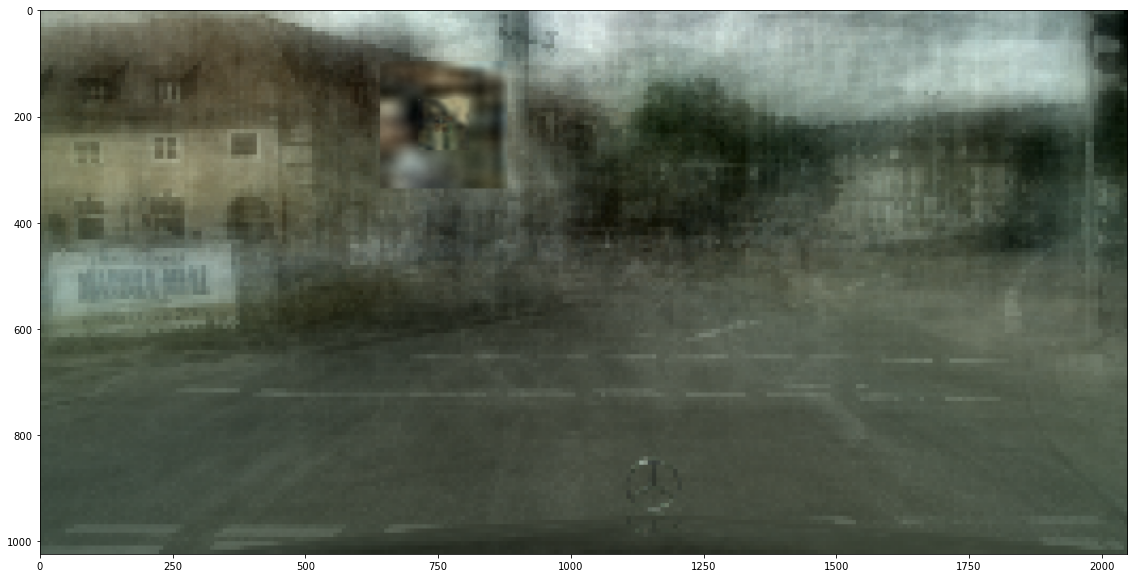

In [43]:
I = dataset.decoder.decode(cologne_000038_feature_grid[3, 20, :])
fig, ax = plt.subplots(figsize = (20, 10))
ax.imshow(I)

In [44]:
feature_grid_path = os.path.join("grids", "cologne_000038_feature_grid_v1.npy")
semantic_grid_path = os.path.join("grids", "cologne_000038_semantic_grid_v1.npy")
with open(feature_grid_path, "wb") as f:
    np.save(f, cologne_000038_feature_grid)

with open(semantic_grid_path, "wb") as f:
    np.save(f, cologne_000038_semantic_grid)

In [45]:
with open(feature_grid_path, "rb") as f:
    cologne_000038_feature_grid = np.load(f, allow_pickle=True)

with open(semantic_grid_path, "rb") as f:
    cologne_000038_semantic_grid = np.load(f, allow_pickle=True)

In [46]:
from sklearn.neighbors import KNeighborsClassifier

dataset = CityScapesDataset("full_dataset_v1_30000")
dataset.load()

toy_feature_subset = [(3, 'mean')]
toy_feature_mask = dataset.get_feature_subset_mask(toy_feature_subset)
tiny_features = dataset.features[:, toy_feature_mask]
tiny_features_normalized = dataset.get_normalized_features()[:, toy_feature_mask]
print(tiny_features_normalized.shape)

foliage_index = 21
foliage_composition = dataset.labels[:, foliage_index]
majority_foliage_mask = foliage_composition > 0.5
print(majority_foliage_mask.sum()) # 4699 of 30000 features are mostly foliage.. sounds a bit high but whatever. 

folliage_nn_classifier = KNeighborsClassifier(3).fit(tiny_features_normalized, majority_foliage_mask)

0.npy
1.npy
2.npy
3.npy
4.npy
5.npy
6.npy


c:\Users\Ben\Documents\UW-Vision-Segmentation\dataset_creation.py:685: RuntimeWarning: invalid value encountered in true_divide
  feature_01 = (features - self.raw_feature_min) / feature_range
c:\Users\Ben\Documents\UW-Vision-Segmentation\dataset_creation.py:704: RuntimeWarning: invalid value encountered in true_divide
  feature_01 = (features - feature_min) / feature_range


(30000, 3)
4699


In [47]:
def folage_nn_prediction_function(normalized_feature: NDArray[Any]):
    toy_feature = normalized_feature[toy_feature_mask]
    is_foliage_hat = folliage_nn_classifier.predict(toy_feature.reshape(1, -1))[0]
    result = np.zeros(30)
    if(is_foliage_hat):
        result[21] = 1.0
    return result

In [48]:
def predict_semantic_grid(feature_grid: NDArray[Any], dataset: CityScapesDataset, use_normalized = True, prediction_fn = None):
    nrows = feature_grid.shape[0]
    ncols = feature_grid.shape[1]
    result = np.zeros((nrows, ncols, 30))
    r = dataset.raw_feature_max - dataset.raw_feature_min
    normalized_feature_grid = np.zeros(feature_grid.shape)
    
    for r in range(nrows):
        for c in range(ncols):
            feature = feature_grid[r, c, :]
            normalized_feature = dataset.normalize_features(np.array([feature]))
            normalized_feature_grid[r, c, :] = normalized_feature
     
    for r in range(nrows):
        for c in range(ncols):
            raw_feature = feature_grid[r, c, :]
            normalized_feature = normalized_feature_grid[r, c, :]

            if(use_normalized):
                prediction = prediction_fn(normalized_feature)
            else:
                prediction = prediction_fn(raw_feature)
            result[r, c, :] = prediction
    return result

In [49]:
R = predict_semantic_grid(cologne_000038_feature_grid, dataset, True, folage_nn_prediction_function)

c:\Users\Ben\Documents\UW-Vision-Segmentation\dataset_creation.py:692: RuntimeWarning: invalid value encountered in true_divide
  feature_01 = (features - self.raw_feature_min) / dataset_feature_range


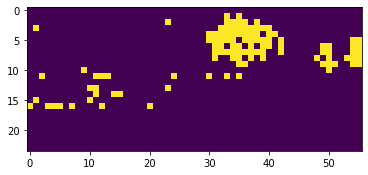

In [50]:
foliage_semantic_map = R[:, :, 21]
fig, ax = plt.subplots()
ax.imshow(foliage_semantic_map)

In [74]:
T = np.array([
    [1, 2, 3],
    [1, 2, 3],
    [2, 3, 4],
    [2, 3, 4]
])
f = np.array([1, 0, 1], dtype=bool)
print(f)
T[:, f]

[ True False  True]


array([[1, 3],
       [1, 3],
       [2, 4],
       [2, 4]])